In [134]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, KFold, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
import time
import cudf
from cuml.ensemble import RandomForestRegressor as cuRF
import math
import xgboost as xgb
from tqdm import tqdm

#### Output file

In [135]:
sourceFile = open("gpu_logs/ensemble_porto_new.txt", 'w')

### Load the data

In [136]:
df = pd.read_pickle("../datasets/df_location.pkl")
## Leaving the first house (public building out) due to its different profile
df = df.iloc[35136:, [0, 2, 1]].reset_index(drop=True)
number_of_houses = df.Location.nunique()
num_samples_per_house = df.Location.value_counts()[1]
df.reset_index(drop=True, inplace=True)
df

,Time,Location,Energy
0,2019-01-01 00:00:00,1,2.322959
1,2019-01-01 00:15:00,1,2.371797
2,2019-01-01 00:30:00,1,2.415961
3,2019-01-01 00:45:00,1,2.302538
4,2019-01-01 01:00:00,1,2.363063
...,...,...,...
1756795,2020-01-01 22:45:00,50,0.753222
1756796,2020-01-01 23:00:00,50,0.716855
1756797,2020-01-01 23:15:00,50,0.735802
1756798,2020-01-01 23:30:00,50,0.485237


In [137]:
#trunc = lambda x: math.trunc(10000 * x) / 10000
#df_trunc = pd.DataFrame(df['Energy']).applymap(trunc)
#df = pd.concat([df.iloc[:, 0:-1], df_trunc], axis=1)
#df

### Auxiliary functions

In [138]:
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()

def truncate_metric(metric):
    m = math.trunc(10000 * metric) / 10000
    return m 
    
def performance_metrics(preds: np.array, actuals: np.array, filename):

    # calculate performance metrics
    
    mse = truncate_metric(mean_squared_error(actuals, preds))
    wape = truncate_metric(np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals))) * 100
    r2 = truncate_metric(r2_score(actuals, preds))
    
    # print performance metrics
    print('MSE: %.4f' % mse, file=filename)
    print('WAPE: %.2f' % wape, file=filename)
    print('R2: %.4f' % r2, file=filename)
    return mse, wape, r2

#@jit(target_backend='cuda')
def build_model(estimator, X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = estimator
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    return model, preds

def validate(estimator, X_train, y_train):
    scores = cross_validate(estimator, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'])
    return scores
    

In [139]:
def total_averaged_metrics(metrics_list, filename):
    
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged WAPE: {}".format(np.round(sum(j for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged R2: {}".format(np.round(sum(k for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)

def past_timesteps(df, number_of_timesteps):
    df = df.sort_values(by=['Location', 'Time'])
    for i in tqdm(range(1, (number_of_timesteps + 1))):
        df.loc[df['Time'].shift(i) == df['Time'] - pd.Timedelta(i * 15, 'm'), f"energy_lag_{i}"] = df['Energy'].shift(i)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def last_energy_points_full(df, number_timesteps, num_samples_per_house):
    X = pd.DataFrame()
    other_feats = df.iloc[:,:2]
    for i in range(1, (number_timesteps + 1) ):
        X[f'Energy_{i*15}'] = df['Energy'].shift(i)
    y = df.copy().iloc[:,2]
    y.iloc[:number_timesteps] = np.nan
    ## Remove samples in between each house
    for h in range(1, number_of_houses):
        for i in range(0, number_timesteps):
            X.iloc[(num_samples_per_house+i)*h] = np.nan
            y.iloc[(num_samples_per_house+i)*h] = np.nan
    X = pd.concat([other_feats, X], axis=1)
    X.dropna(inplace=True)
    X.reset_index(drop=True, inplace=True)
    y.dropna(inplace=True)
    y.reset_index(drop=True, inplace=True)
    y.columns = ["Energy"]
    dataframe = pd.concat([X,y.rename('Energy')], axis=1)
    assert number_of_houses == (df.shape[0] - dataframe.shape[0]) / number_timesteps, "Something went wrong with preprocessing"
    return dataframe
    

In [140]:
def normalize_training(X_train):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    return X_train, scaler

### Cross Validate

In [141]:
#scores = validate(xgb.XGBRegressor(seed=0), X_train, y_train)
#cv_mse = np.round(scores['test_neg_mean_squared_error'].mean() * (-1),4)
#cv_r2 = np.round(scores['test_r2'].mean(),5)
#print("CV MSE: {} ".format(cv_mse))
#print("CV R2: {} ".format(cv_r2))
#metrics_list.append((cv_mse,cv_rmse,cv_mae,mape,cv_r2))

## Leave 10 houses for test (demonstration)

In [142]:
number_of_timesteps = 12

In [143]:
df_new = past_timesteps(df, number_of_timesteps)
df_new

100%|██████████| 12/12 [00:00<00:00, 34.74it/s]


,Time,Location,Energy,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,energy_lag_5,energy_lag_6,energy_lag_7,energy_lag_8,energy_lag_9,energy_lag_10,energy_lag_11,energy_lag_12
0,2019-01-01 03:00:00,1,2.406489,2.443886,2.342396,2.402921,2.341043,2.316070,2.299585,2.334031,2.363063,2.302538,2.415961,2.371797,2.322959
1,2019-01-01 03:15:00,1,2.378686,2.406489,2.443886,2.342396,2.402921,2.341043,2.316070,2.299585,2.334031,2.363063,2.302538,2.415961,2.371797
2,2019-01-01 03:30:00,1,2.338582,2.378686,2.406489,2.443886,2.342396,2.402921,2.341043,2.316070,2.299585,2.334031,2.363063,2.302538,2.415961
3,2019-01-01 03:45:00,1,2.256406,2.338582,2.378686,2.406489,2.443886,2.342396,2.402921,2.341043,2.316070,2.299585,2.334031,2.363063,2.302538
4,2019-01-01 04:00:00,1,2.298232,2.256406,2.338582,2.378686,2.406489,2.443886,2.342396,2.402921,2.341043,2.316070,2.299585,2.334031,2.363063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756195,2020-01-01 22:45:00,50,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,0.533286,0.533451,0.464143,0.552398,0.937120
1756196,2020-01-01 23:00:00,50,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,0.533286,0.533451,0.464143,0.552398
1756197,2020-01-01 23:15:00,50,0.735802,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,0.533286,0.533451,0.464143
1756198,2020-01-01 23:30:00,50,0.485237,0.735802,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,0.533286,0.533451


In [144]:
df_new.isna().sum()

Time             0
Location         0
Energy           0
energy_lag_1     0
energy_lag_2     0
energy_lag_3     0
energy_lag_4     0
energy_lag_5     0
energy_lag_6     0
energy_lag_7     0
energy_lag_8     0
energy_lag_9     0
energy_lag_10    0
energy_lag_11    0
energy_lag_12    0
dtype: int64

In [145]:
def test_leave_house_out(df, estimator, number_timesteps, num_houses_test, locations, filename):
    df_new = past_timesteps(df, number_timesteps)
    df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
    df_new['Weekend'] = df_new['Time'].dt.dayofweek.isin([5,6]).astype(int)
    df_new['Hour'] = df_new['Time'].dt.hour
    test = df_new[df_new['Location'].isin(locations)]
    train = df_new[~df_new['Location'].isin(locations)]
    print("Train set: ", train.shape)
    print("Test set: ", test.shape)
    X_train = train.drop(['Time', 'Energy', 'Location'], axis=1)
    X_test = test.drop(['Time', 'Energy', 'Location'], axis=1)
    y_train = train['Energy']
    y_test = test['Energy']
    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)

    model = estimator
    init = time.time()
    model.fit(X_train_norm, y_train)
    y_pred = model.predict(X_test_norm)
    end = time.time()
    print('Elapsed time: {:.4f} s'.format(end - init), file=filename)
    mse, wape, r2 = performance_metrics(y_pred, y_test.values.reshape(-1), filename)
    return mse, wape, r2, model

## Predict  10 folds with 10 random houses for test

In [146]:
num_houses_test = 10

In [147]:
kf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42) 
locations = []
for _, test_index in kf.split(df['Location'].unique()):
    locations.append(test_index)
locations

[array([13, 17, 19, 25, 26, 30, 32, 39, 45, 48]),
 array([ 3,  4,  6,  8, 12, 15, 37, 41, 46, 47]),
 array([ 0,  5,  9, 16, 24, 27, 31, 33, 34, 44]),
 array([ 1,  2, 11, 21, 23, 29, 35, 36, 40, 43]),
 array([ 7, 10, 14, 18, 20, 22, 28, 38, 42, 49]),
 array([ 0,  2, 10, 22, 29, 38, 39, 44, 45, 46]),
 array([ 4, 12, 18, 21, 24, 30, 31, 32, 33, 49]),
 array([ 9, 14, 15, 20, 23, 26, 36, 40, 41, 42]),
 array([ 3,  5, 11, 16, 17, 28, 35, 37, 47, 48]),
 array([ 1,  6,  7,  8, 13, 19, 25, 27, 34, 43])]

In [148]:
locations = []
for i in range(10):
    l = np.random.choice(df['Location'].unique(), size=num_houses_test, replace=False)
    locations.append(l)
locations

[array([50, 36, 38, 21, 34, 11,  6, 44, 10,  5]),
 array([16, 11, 35, 43, 12, 10,  9, 48, 34, 27]),
 array([49, 41, 32, 23, 10,  1, 24, 42, 27, 37]),
 array([ 4, 11, 40, 49, 35, 33, 21,  9, 15, 37]),
 array([ 6, 35, 38, 50, 42, 26, 43, 20, 11, 27]),
 array([ 9, 44, 18,  4, 28, 25, 45, 50, 15, 12]),
 array([18, 22, 16,  6, 44, 25, 46,  5, 36,  3]),
 array([16, 24, 10,  3,  2, 49, 41, 36,  7, 21]),
 array([37, 40, 39, 50, 48,  1, 38,  5, 43, 28]),
 array([50, 21, 28, 49,  5,  6,  7, 18, 41, 38])]

### Linear Regression

In [149]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), number_of_timesteps, num_houses_test, locations[i], sourceFile)
    metrics_list_lr.append((mse, wape, r2))

100%|██████████| 12/12 [00:00<00:00, 34.68it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


100%|██████████| 12/12 [00:00<00:00, 34.92it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


100%|██████████| 12/12 [00:00<00:00, 35.13it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


100%|██████████| 12/12 [00:00<00:00, 35.05it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


100%|██████████| 12/12 [00:00<00:00, 35.04it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


100%|██████████| 12/12 [00:00<00:00, 33.86it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


100%|██████████| 12/12 [00:00<00:00, 34.64it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


100%|██████████| 12/12 [00:00<00:00, 34.90it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


100%|██████████| 12/12 [00:00<00:00, 35.15it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


100%|██████████| 12/12 [00:00<00:00, 35.05it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


### XGBoost

In [150]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0), number_of_timesteps, num_houses_test, locations[i], sourceFile)
    metrics_list_xgb.append((mse, wape, r2))

100%|██████████| 12/12 [00:00<00:00, 34.39it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


100%|██████████| 12/12 [00:00<00:00, 34.71it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


100%|██████████| 12/12 [00:00<00:00, 35.45it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


100%|██████████| 12/12 [00:00<00:00, 34.59it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


100%|██████████| 12/12 [00:00<00:00, 34.91it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


100%|██████████| 12/12 [00:00<00:00, 35.23it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


100%|██████████| 12/12 [00:00<00:00, 36.66it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


100%|██████████| 12/12 [00:00<00:00, 42.05it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


100%|██████████| 12/12 [00:00<00:00, 38.03it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


100%|██████████| 12/12 [00:00<00:00, 35.48it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


### Random Forest

In [151]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_rf = test_leave_house_out(df, cuRF(), number_of_timesteps, num_houses_test, locations[i], sourceFile)
    metrics_list_rf.append((mse, wape, r2))

100%|██████████| 12/12 [00:00<00:00, 34.71it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
100%|██████████| 12/12 [00:00<00:00, 35.49it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
100%|██████████| 12/12 [00:00<00:00, 36.65it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
100%|██████████| 12/12 [00:00<00:00, 36.63it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
100%|██████████| 12/12 [00:00<00:00, 35.05it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
100%|██████████| 12/12 [00:00<00:00, 35.15it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
100%|██████████| 12/12 [00:00<00:00, 35.95it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
100%|██████████| 12/12 [00:00<00:00, 39.77it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
100%|██████████| 12/12 [00:00<00:00, 35.89it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
100%|██████████| 12/12 [00:00<00:00, 36.11it/s]


Train set:  (1404960, 18)
Test set:  (351240, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


## Averaged Metrics

In [152]:
print("\n\n\n", file=sourceFile)

In [153]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

In [154]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

In [155]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

### Feature Importance

In [156]:
print('Linear Regression\n')
for i,v in enumerate(model_lr.coef_):
    print('Feature: %0d, Score: %.5f' % (i,v))
print('XGBoost\n')
for i,v in enumerate(model_xgb.feature_importances_):
    print('Feature: %0d, Score: %.5f' % (i,v))

Linear Regression

Feature: 0, Score: 8.88558
Feature: 1, Score: -1.17607
Feature: 2, Score: 1.37698
Feature: 3, Score: -0.47252
Feature: 4, Score: 0.82314
Feature: 5, Score: 0.14699
Feature: 6, Score: 0.00514
Feature: 7, Score: -0.19721
Feature: 8, Score: 0.28610
Feature: 9, Score: 0.04687
Feature: 10, Score: 0.02537
Feature: 11, Score: -0.01068
Feature: 12, Score: 0.00992
Feature: 13, Score: -0.00450
Feature: 14, Score: 0.05035
XGBoost

Feature: 0, Score: 0.87490
Feature: 1, Score: 0.01513
Feature: 2, Score: 0.02104
Feature: 3, Score: 0.00810
Feature: 4, Score: 0.01494
Feature: 5, Score: 0.00936
Feature: 6, Score: 0.00793
Feature: 7, Score: 0.00659
Feature: 8, Score: 0.00690
Feature: 9, Score: 0.00659
Feature: 10, Score: 0.00594
Feature: 11, Score: 0.00662
Feature: 12, Score: 0.00473
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.01121


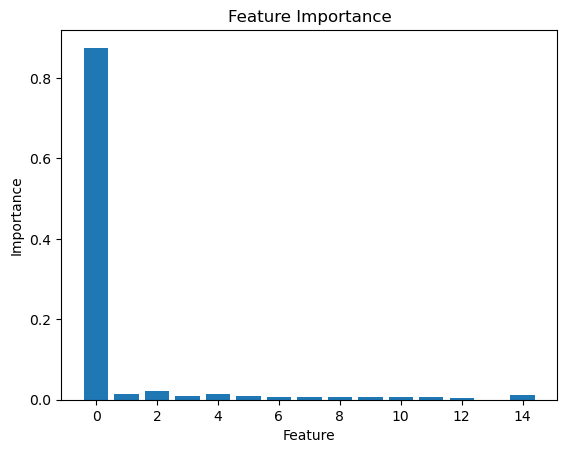

In [157]:
plt.bar(range(len(model_xgb.feature_importances_)),model_xgb.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

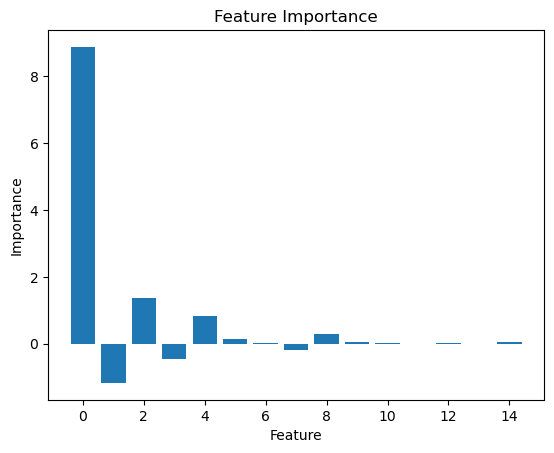

In [158]:
plt.bar(range(len(model_lr.coef_)),model_lr.coef_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [159]:
sourceFile.close()